In [ ]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import pickle as pkl

batch_size = 64
num_epochs = 50
# if train with MNIST dataset, set dataset = "MNIST"
# else the training dataset is FashionMNIST
dataset = "MNIST"

In [ ]:
def prepare_data_loader():
    if dataset == "MNIST":
        train_data = datasets.MNIST(root='data', train=True,
                                           download=True, transform=transforms.ToTensor())
    else:
        train_data = datasets.FashionMNIST(root='data', train=True,
                                    download=True, transform=transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=0)
    return train_loader

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, d_input_size=28*28, d_output_size=1):
        super(Discriminator, self).__init__()
        negative_slove = 0.2
        self.model = nn.Sequential(
            nn.Linear(d_input_size, 128),
            nn.LeakyReLU(negative_slove, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slove, inplace=True),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slove, inplace=True),
            nn.Linear(32, d_output_size),
            nn.Sigmoid(),
        )

    def forward(self, img):
        x = img.view(-1, 28*28)
        return self.model(x)


In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_size=100, g_output_size=28*28):
        super(Generator, self).__init__()
        negative_slove = 0.2
        self.model = nn.Sequential(
            nn.Linear(g_input_size, 32),
            nn.LeakyReLU(negative_slove),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slove, inplace=True),
            nn.Linear(64, 128),
            nn.LeakyReLU(negative_slove, inplace=True),
            nn.Linear(128, g_output_size),
            nn.Tanh(),
        )
    def forward(self, z):
        fake_img = self.model(z)
        return fake_img


In [ ]:
def real_loss(D_out, smooth=False):
    D_out_size = D_out.size(0)
    real_img_label = torch.ones(D_out_size)
    if smooth:
        real_img_label *= 0.9
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), real_img_label)
    return loss

def fake_loss(D_out):
    D_out_size = D_out.size(0)
    fake_img_label = torch.zeros(D_out_size)
    criterion = nn.BCELoss()
    loss = criterion(D_out.squeeze(), fake_img_label)
    return loss

In [ ]:
def prepare_optimizer(D,G):
    lr = 0.002
    betas = (0.5, 0.999)
    d_optimizer = torch.optim.Adam(D.parameters(), lr, betas)
    g_optimizer = torch.optim.Adam(G.parameters(), lr, betas)
    return d_optimizer, g_optimizer

In [ ]:
def train(num_epochs = 10):
    train_loader = prepare_data_loader()
    D = Discriminator()
    G = Generator()
    d_optimizer, g_optimizer = prepare_optimizer(D, G)
    samples = []
    losses = []

    fixed_z = np.random.uniform(-1, 1, size=(16, 100))
    fixed_z = torch.from_numpy(fixed_z).float()
    G.eval()
    fake_img = G(fixed_z)
    samples.append(fake_img)

    d_fake_losses = []
    d_real_losses = []
    D.train()
    G.train()
    for epoch in range(num_epochs):
        d_losses = []
        g_losses = []
        for batch_i, (real_imgs, label) in enumerate(train_loader):
            batch_size = real_imgs.size(0)
            ########################
            # Discrininator training
            ########################
            # scale input from [0,1) to [-1,1)
            real_imgs = real_imgs * 2 - 1
            d_optimizer.zero_grad()
            d_real_loss = real_loss(D(real_imgs), smooth=True)

            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(batch_size, 100))
                z = torch.from_numpy(z).float()
            d_fake_loss = fake_loss(D(G(z)))
            # save d_fake_loss and d_real_loss 
            d_fake_losses.append(d_fake_loss)
            d_real_losses.append(d_real_loss)
            # caculate d_loss
            d_loss = d_fake_loss + d_real_loss
            d_loss.backward()
            d_optimizer.step()

            ####################
            # Generator training
            ####################
            g_optimizer.zero_grad()
            with torch.no_grad():
                z = np.random.uniform(-1, 1, size=(batch_size, 100))
                z = torch.from_numpy(z).float()
            g_loss = real_loss(D(G(z)))
            g_loss.backward()
            g_optimizer.step()

            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())

        # save means of d_loss, g_loss
        losses.append((np.mean(d_losses), np.mean(g_losses)))
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
            epoch + 1, num_epochs, np.mean(d_losses), np.mean(g_losses)))

        # save generated image each epoch
        G.eval()
        fake_img = G(fixed_z)
        samples.append(fake_img)
        G.train()
    if dataset == "MNIST":
      with open('train_MNIST_losses.pkl', 'wb') as file:
          pkl.dump(losses, file)
      with open('train_MNIST_samples.pkl', 'wb') as file:
          pkl.dump(samples, file)
      with open('train_MNIST_d_fake_losses.pkl', 'wb') as file:
          pkl.dump(d_fake_losses, file)
      with open('train_MNIST_d_real_losses.pkl', 'wb') as file:
          pkl.dump(d_real_losses, file)

    else:
      with open('train_FashionMNIST_losses.pkl', 'wb') as file:
          pkl.dump(losses, file)
      with open('train_FashionMNIST_samples.pkl', 'wb') as file:
          pkl.dump(samples, file)

In [ ]:
# Start training with MNIST dataset
train(num_epochs)

Epoch [    1/   50] | d_loss: 1.2207 | g_loss: 1.1936
Epoch [    2/   50] | d_loss: 1.1030 | g_loss: 1.4974
Epoch [    3/   50] | d_loss: 1.0948 | g_loss: 1.4944
Epoch [    4/   50] | d_loss: 1.1163 | g_loss: 1.4151
Epoch [    5/   50] | d_loss: 1.1202 | g_loss: 1.3885
Epoch [    6/   50] | d_loss: 1.1294 | g_loss: 1.3710
Epoch [    7/   50] | d_loss: 1.1112 | g_loss: 1.4016
Epoch [    8/   50] | d_loss: 1.1248 | g_loss: 1.3742
Epoch [    9/   50] | d_loss: 1.1204 | g_loss: 1.3818
Epoch [   10/   50] | d_loss: 1.1092 | g_loss: 1.4162
Epoch [   11/   50] | d_loss: 1.0859 | g_loss: 1.4765
Epoch [   12/   50] | d_loss: 1.0877 | g_loss: 1.4753
Epoch [   13/   50] | d_loss: 1.0712 | g_loss: 1.5143
Epoch [   14/   50] | d_loss: 1.0620 | g_loss: 1.5520
Epoch [   15/   50] | d_loss: 1.0506 | g_loss: 1.5778
Epoch [   16/   50] | d_loss: 1.0464 | g_loss: 1.5834
Epoch [   17/   50] | d_loss: 1.0441 | g_loss: 1.6076
Epoch [   18/   50] | d_loss: 1.0258 | g_loss: 1.6576
Epoch [   19/   50] | d_loss

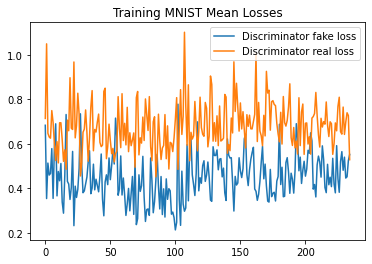

In [ ]:
def show_D_training_loss():
  if dataset =="MNIST":
    with open('train_MNIST_d_fake_losses.pkl', 'rb') as file:
        d_fake_losses = pickle.load(file)
    with open('train_MNIST_d_real_losses.pkl', 'rb') as file:
        d_real_losses = pickle.load(file)
  else:
    with open('train_FashionMNIST_d_fake_losses.pkl', 'rb') as file:
        d_fake_losses = pickle.load(file)
    with open('train_FashionMNIST_d_real_losses.pkl', 'rb') as file:
        d_real_losses = pickle.load(file)
  fig, ax = plt.subplots()
  
  plt.plot(d_fake_losses[::400], label='D fake loss')
  plt.plot(d_real_losses[::400], label='D real loss')
  if dataset =="MNIST":
    plt.title("Training MNIST")
  else:
    plt.title("Training FashionMNIST")
  plt.legend()
  plt.show()

show_training_loss()

In [ ]:
def show_training_loss():
  if dataset =="MNIST":
    with open('train_MNIST_losses.pkl', 'rb') as file:
        losses = pickle.load(file)
        
  else:
    with open('train_FashionMNIST_losses.pkl', 'rb') as file:
        losses = pickle.load(file)
  print(11)
  fig, ax = plt.subplots()
  losses = np.array(losses)
  plt.plot(losses.T[0], label='Discriminator')
  plt.plot(losses.T[1], label='Generator')
  if dataset =="MNIST":
    plt.title("Training MNIST Mean Losses")
  else:
    plt.title("Training FashionMNIST Mean Losses")
  plt.legend()
  plt.show()

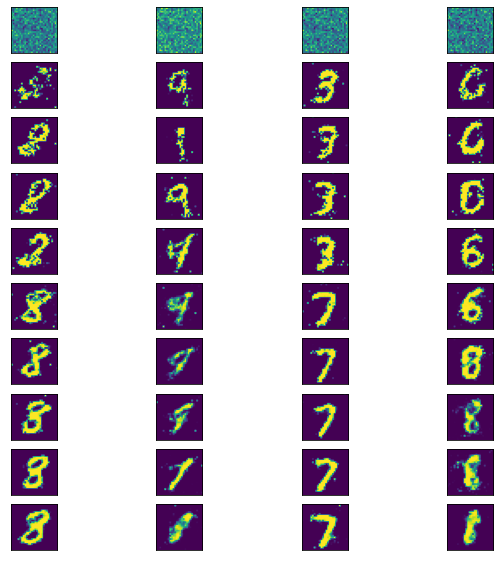

In [ ]:
def view_samples(num_epoch=10):
  if dataset =="MNIST":
    with open('train_MNIST_samples.pkl', 'rb') as file:
        samples = pkl.load(file)
  else:
    with open('train_FashionMNIST_samples.pkl', 'rb') as file:
        samples = pkl.load(file)
  rows = 10
  cols = 4
  fig, axes = plt.subplots(figsize=(10,10), nrows=rows, ncols=cols, sharey=True, sharex=True)
  for sample, ax_row in zip(samples[::int(len(samples) / rows)], axes):
      for img, ax in zip(sample[::int(len(sample) / cols)], ax_row):
          img = img.detach()
          ax.xaxis.set_visible(False)
          ax.yaxis.set_visible(False)
          ax.imshow(img.reshape((28, 28)))
  plt.show()

view_samples(num_epochs)